In [1]:
import os
import pandas as pd
import datetime
import dateutil.parser
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imread

import helpers

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)

In [3]:
DOLLARS_PER_SCAN = 0.07

badgeMapping = {
    "blocker":"Aiden Ray",
    'Tiara': "probably valentine",
    'daniel':"Fred Holt",
    'Julia': "",
    'Zoheb':"NT",
    'betsabe':"",
    'simon':"",
    'Hugh':"Louise Villmunsen",
    'aron':"James Grose",
    'Yudie':"Louise Villmunsen",
    'rick':"Fred Holt",
    'arjun':"Louise Villmunsen",
    "alicia":"valentine",
    "taha":"Aiden Ray",
    "michael":"NT",
    "julia2":"minor375",
    "aliasgher":"connor",
    "mufaddal":"kirsten karst",
    "yudi2":"NT"
}

In [4]:
def getiOS_df(path):
    def mergeTimeDate(x):
        return dateutil.parser.parse(x[u' Date'] + " " + x[u' Time'])

    df = pd.DataFrame.from_dict( pd.read_csv(path,
                                             header=0) 
                               )
    df["timeStamp"] = df.apply(lambda x: mergeTimeDate(x), axis=1 )
    df = df.drop([u' Date',u' Time', u'Name'], 1)
    df.columns = ["stickerID","timeStamp"]
    return df 

def getAndroid_df(path):
    def convertTimeStamp(x):
        return dateutil.parser.parse(x["timeStamp"])
    df = pd.read_csv( path, 
                      header=None,
                      names=["stickerID","detectionType","xstickerID","timeStamp","xID"])
    df["tempTimeStamp"] = df.apply(lambda x: convertTimeStamp(x), axis=1 )
    df = df.drop(["xstickerID","detectionType","xID","timeStamp"], 1)
    df.columns = ["stickerID","timeStamp"]
    return pd.DataFrame.from_dict(df)

In [5]:
dirs = os.listdir(u'scan data')

allData = []
for d in dirs:
    path = u'scan data/'+d
    csvs = os.listdir(path)
    thisPersonsData = []
    for csv in csvs:
        tempdf = pd.DataFrame.from_dict( pd.read_csv(path+"/"+csv ,header=None))
        if tempdf.shape[1] > 4: #more than 4 means iPhone
            df = getAndroid_df(path+"/"+csv)
        else:
            df = getiOS_df(path+"/"+csv)
        df["person"] = d
        df["badge"]  = badgeMapping[d]
        df = df[df.stickerID<400]
        thisPersonsData.append( df )
        
    allthisPersonsData = pd.concat(thisPersonsData).drop_duplicates()
    if d == "Yudie":
        allthisPersonsData = allthisPersonsData[allthisPersonsData.timeStamp > datetime.datetime(2016, 11, 25, 16, 0)]
    print d, allthisPersonsData.shape
        
    allData.append({"data": allthisPersonsData, "name": d})

yudi2
Tiara
daniel
Yudie
(1101, 4)
Julia
julia2
alicia
Zoheb
rick
betsabe
blocker
aliasgher
michael
simon
taha
Hugh
aron
mufaddal
arjun


In [6]:
allUniqueDetections = pd.concat([x["data"] for x in allData])
print allUniqueDetections.shape #just checking that the numbers meet up different ways
allUniqueDetections.head(5)

(29165, 4)


,stickerID,timeStamp,person,badge
0,68,2016-11-28 17:36:39,yudi2,NT
1,67,2016-11-28 17:36:30,yudi2,NT
2,77,2016-11-28 17:36:24,yudi2,NT
3,81,2016-11-28 17:36:20,yudi2,NT
4,77,2016-11-28 17:36:14,yudi2,NT


In [7]:
people = []
for p in allData:
    df = p["data"]
    timeWindowLength = (df.timeStamp.max()-df.timeStamp.min()).total_seconds()/60/60
    if timeWindowLength > 0:
        person = {}
        person["name"] = p["name"]
        person["detections"]  = df.shape[0]
        person["first"] = df.timeStamp.min()
        person["last"]  = df.timeStamp.max()
        person["time_spent"]  = timeWindowLength
        person["hourly_rate"] = (df.shape[0]*DOLLARS_PER_SCAN)/timeWindowLength
        person["owed"]        = df.shape[0]*DOLLARS_PER_SCAN
        person["total"]       = df.shape[0]*DOLLARS_PER_SCAN + 20
        
        people.append(person)
    else:
        print p["name"], "Zero length time period\n"


peopleDF = pd.DataFrame.from_dict(people).sort_values(by="owed",ascending=False)
print "Total detections:", peopleDF.detections.sum()
print peopleDF.shape[0],"sessions"
peopleDF

Total detections: 29165
19 sessions


,detections,first,hourly_rate,last,name,owed,time_spent,total
11,3757,2016-11-28 09:52:16,42.689332,2016-11-28 16:01:54,aliasgher,262.99,6.160556,282.99
5,3312,2016-11-25 13:20:34,3.064133,2016-11-28 17:00:19,julia2,231.84,75.662500,251.84
14,3242,2016-11-27 09:06:00,34.302557,2016-11-27 15:42:57,taha,226.94,6.615833,246.94
12,2760,2016-11-27 08:48:00,29.058701,2016-11-27 15:26:55,michael,193.20,6.648611,213.20
17,2726,2016-11-28 09:52:15,38.703702,2016-11-28 14:48:04,mufaddal,190.82,4.930278,210.82
0,2486,2016-11-25 16:18:27,2.343897,2016-11-28 18:33:05,yudi2,174.02,74.243889,194.02
6,2321,2016-11-27 09:33:00,25.932961,2016-11-27 15:48:54,alicia,162.47,6.265000,182.47
18,2104,2016-11-27 10:04:41,25.790836,2016-11-27 15:47:19,arjun,147.28,5.710556,167.28
4,1516,2016-11-25 13:20:34,29.198410,2016-11-25 16:58:38,Julia,106.12,3.634444,126.12
3,1101,2016-11-25 16:00:04,29.718509,2016-11-25 18:35:40,Yudie,77.07,2.593333,97.07


In [8]:
peopleDF.total.sum()

2421.5500000000002

In [9]:
message = "".join([ "Hi,\n",
                    "Thanks for coming in today, we took a big bite out of the target ",
                    "I've got you down as scanning {detections} stickers ",
                    "between {first} and {last} (that's {time_spent:.2f} hours).\n",
                    "I'm going to add $20 to cover getting you set up and that kind ",
                    "of thing, and to bump the per scan rate to $0.07, so that's ${owed} ",
                    "for scans, ${total} total that I owe you. If you're keeping track of ",
                    "this stuff, that's ${hourly_rate:.2f} an hour. (Just on scans.)\n",
                    "If you’d like to come back and do some more then it’d be great to have you. I’ve got to move house tomorrow, so I’m not going to be around, but Sunday and next week should be fine.\n",
                    "Ben\n"])
for r in peopleDF.itertuples():
    print r.name
    d = dict(r._asdict())
    print message.format(**d)

aliasgher
Hi,
Thanks for coming in today, we took a big bite out of the target I've got you down as scanning 3757 stickers between 2016-11-28 09:52:16 and 2016-11-28 16:01:54 (that's 6.16 hours).
I'm going to add $20 to cover getting you set up and that kind of thing, and to bump the per scan rate to $0.07, so that's $262.99 for scans, $282.99 total that I owe you. If you're keeping track of this stuff, that's $42.69 an hour. (Just on scans.)
If you’d like to come back and do some more then it’d be great to have you. I’ve got to move house tomorrow, so I’m not going to be around, but Sunday and next week should be fine.
Ben

julia2
Hi,
Thanks for coming in today, we took a big bite out of the target I've got you down as scanning 3312 stickers between 2016-11-25 13:20:34 and 2016-11-28 17:00:19 (that's 75.66 hours).
I'm going to add $20 to cover getting you set up and that kind of thing, and to bump the per scan rate to $0.07, so that's $231.84 for scans, $251.84 total that I owe you. I

In [10]:
everything = pd.concat([x["data"] for x in allData])
everything.stickerID = pd.to_numeric(everything.stickerID) 
everything.reset_index(drop=True, inplace=True)
everything.head(3)


,stickerID,timeStamp,person,badge
0,68,2016-11-28 17:36:39,yudi2,NT
1,67,2016-11-28 17:36:30,yudi2,NT
2,77,2016-11-28 17:36:24,yudi2,NT


68 <type 'numpy.int64'>


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff39b566d90>]], dtype=object)

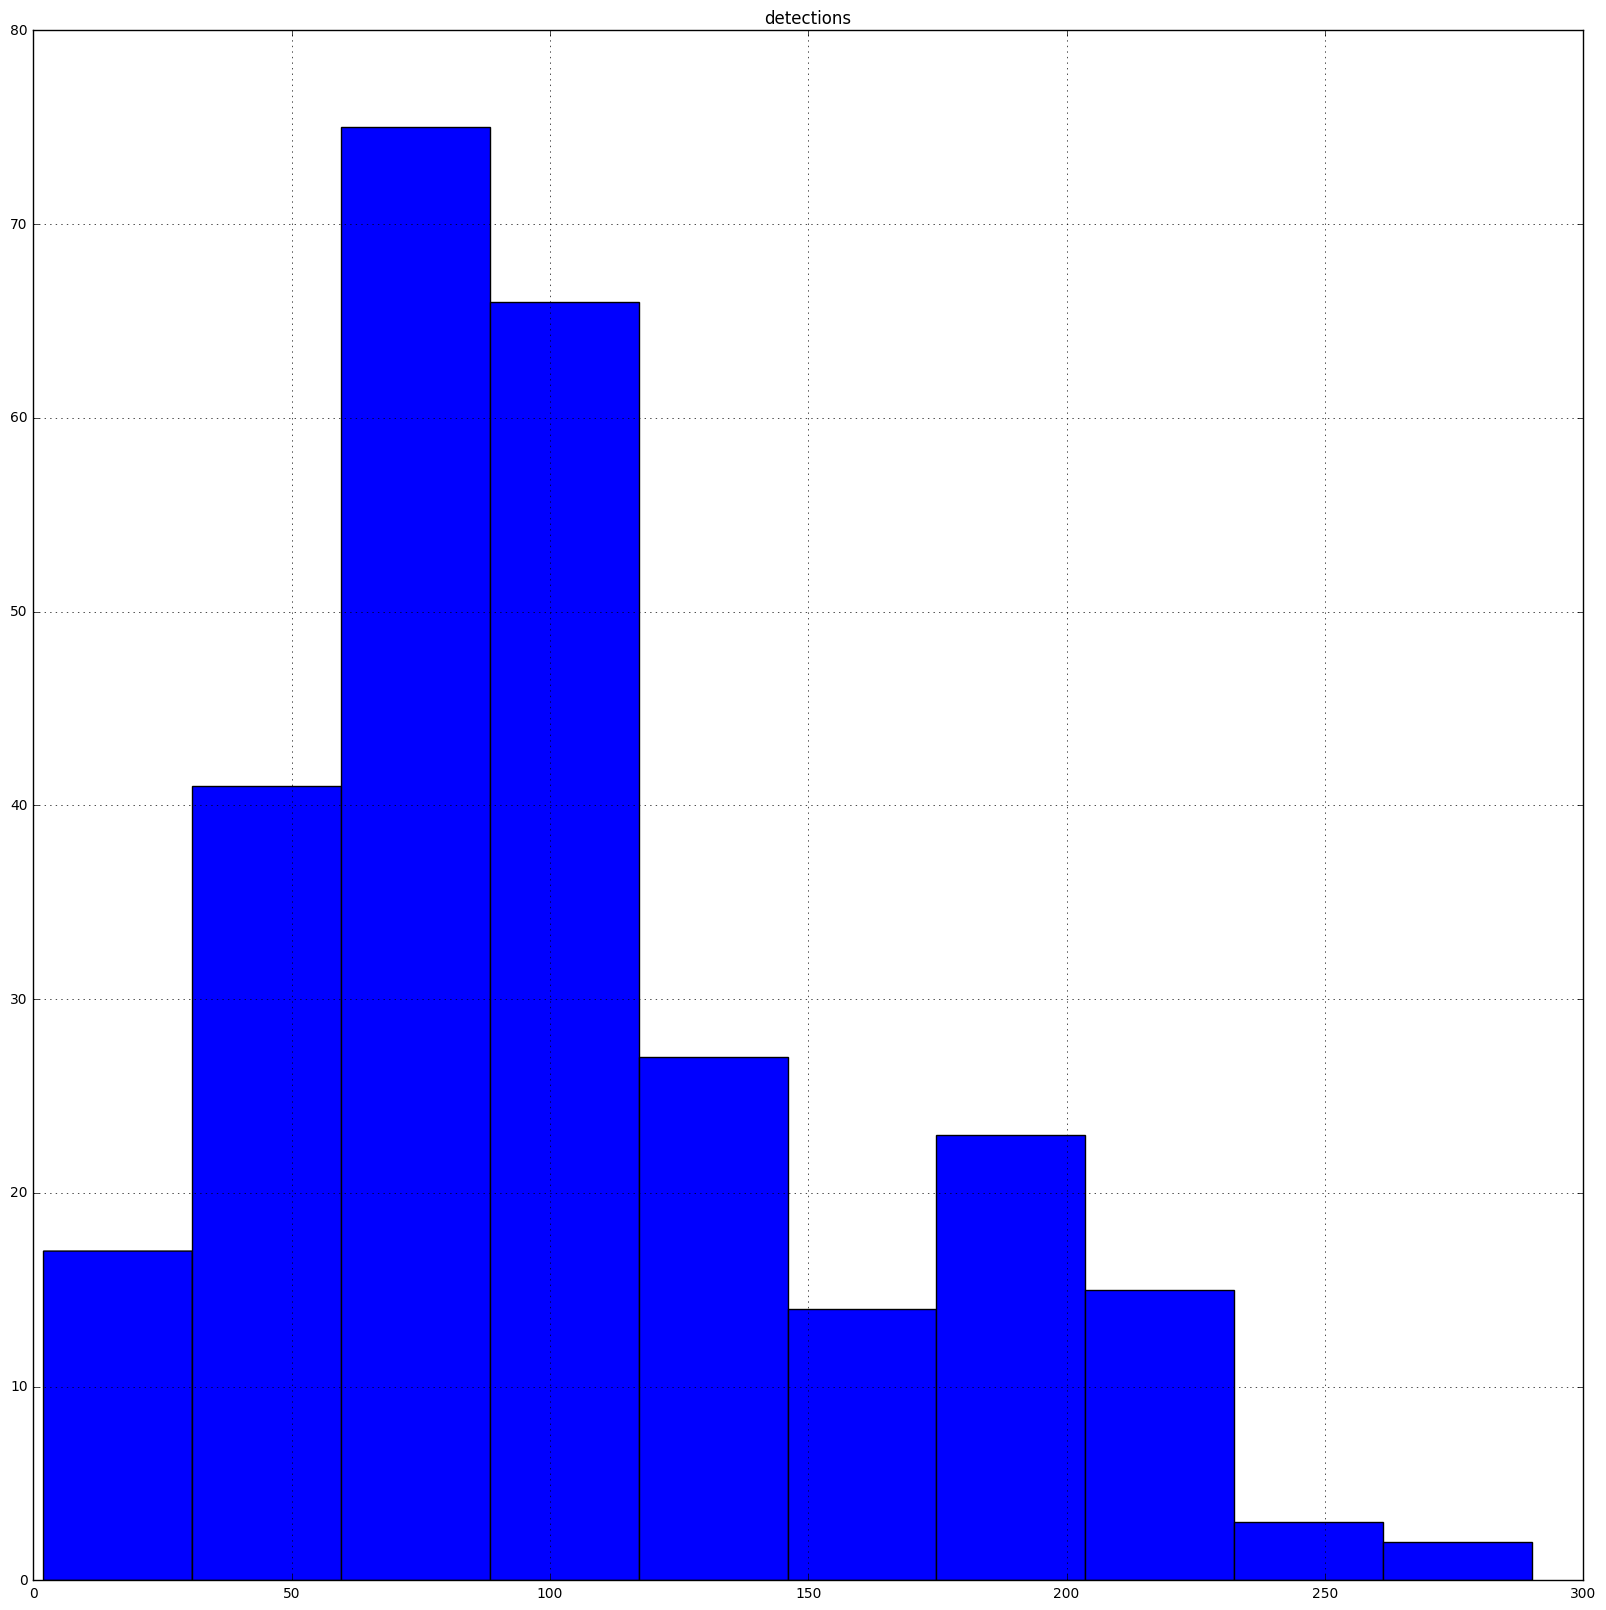

In [11]:
print everything.stickerID[0], type(everything.stickerID[0])
uniq = everything.stickerID.unique()
bins = {}
for u in uniq:
    bins[u] = []
    
scans = list(everything.stickerID)
for s in scans:
    bins[s].append(s)

for k in bins.keys():
    bins[k] = len(bins[k])
    
binDF = pd.DataFrame.from_dict(bins,orient='index')
binDF.columns = ["detections"]
binDF.hist()

In [12]:
stickerLocations = helpers.getDFfromCSVURL("https://docs.google.com/spreadsheets/d/1sijQZR2iFLo2FS_3r5gbsuAkaglRz557LWjdLxnPkpE/pub?gid=0&single=true&output=csv")
stickerLocations = stickerLocations.drop(["z","raw"], 1) # this is just because we aren't on multiple floors
stickerLocations.head(3)

,stickerID,x,y
0,1,63852.09440,-13561.617780
1,2,62985.85359,-11830.460440
2,3,62985.85359,-9830.460444


In [13]:
baseStationData = helpers.getDFfromCSVURL("https://docs.google.com/spreadsheets/d/167pxh_NRq5e9sQV9Zb8Z-Q-kdN7Zy9FCzCp47eVXTuE/pub?gid=1446311565&single=true&output=csv")
baseStationData = baseStationData.ix[:,0:5] #only keep the columns we care about
baseStationData = baseStationData.drop(["location"], 1)
baseStationData = baseStationData[baseStationData.agentId > 0] #not really sure how this works, maybe failure is falsy?
baseStationData.head(3)
baseStationData.agentName.unique()

array(['Ace', 'Alfa', 'Beer', 'Bravo', 'Charlie', 'Coco', 'Dee', 'Echo',
       'Edward', 'Foxtrot', 'Hotel', 'George', 'Golf', 'Harry', 'Freddie',
       'India', 'Ink', 'Johnnie', 'Juliett', 'Kilo', 'King', 'Lima',
       'London', 'Mike', 'Monkey', 'November', 'Nuts', 'Orange', 'Oscar',
       'Papa', 'Pip', 'Quebec', 'Queen', 'Robert', 'Romeo', 'Sierra',
       'Sugar', 'Tango', 'Tick', 'Uncle', 'Uniform', 'Vic', 'Victor',
       'Whisky', 'William'], dtype=object)

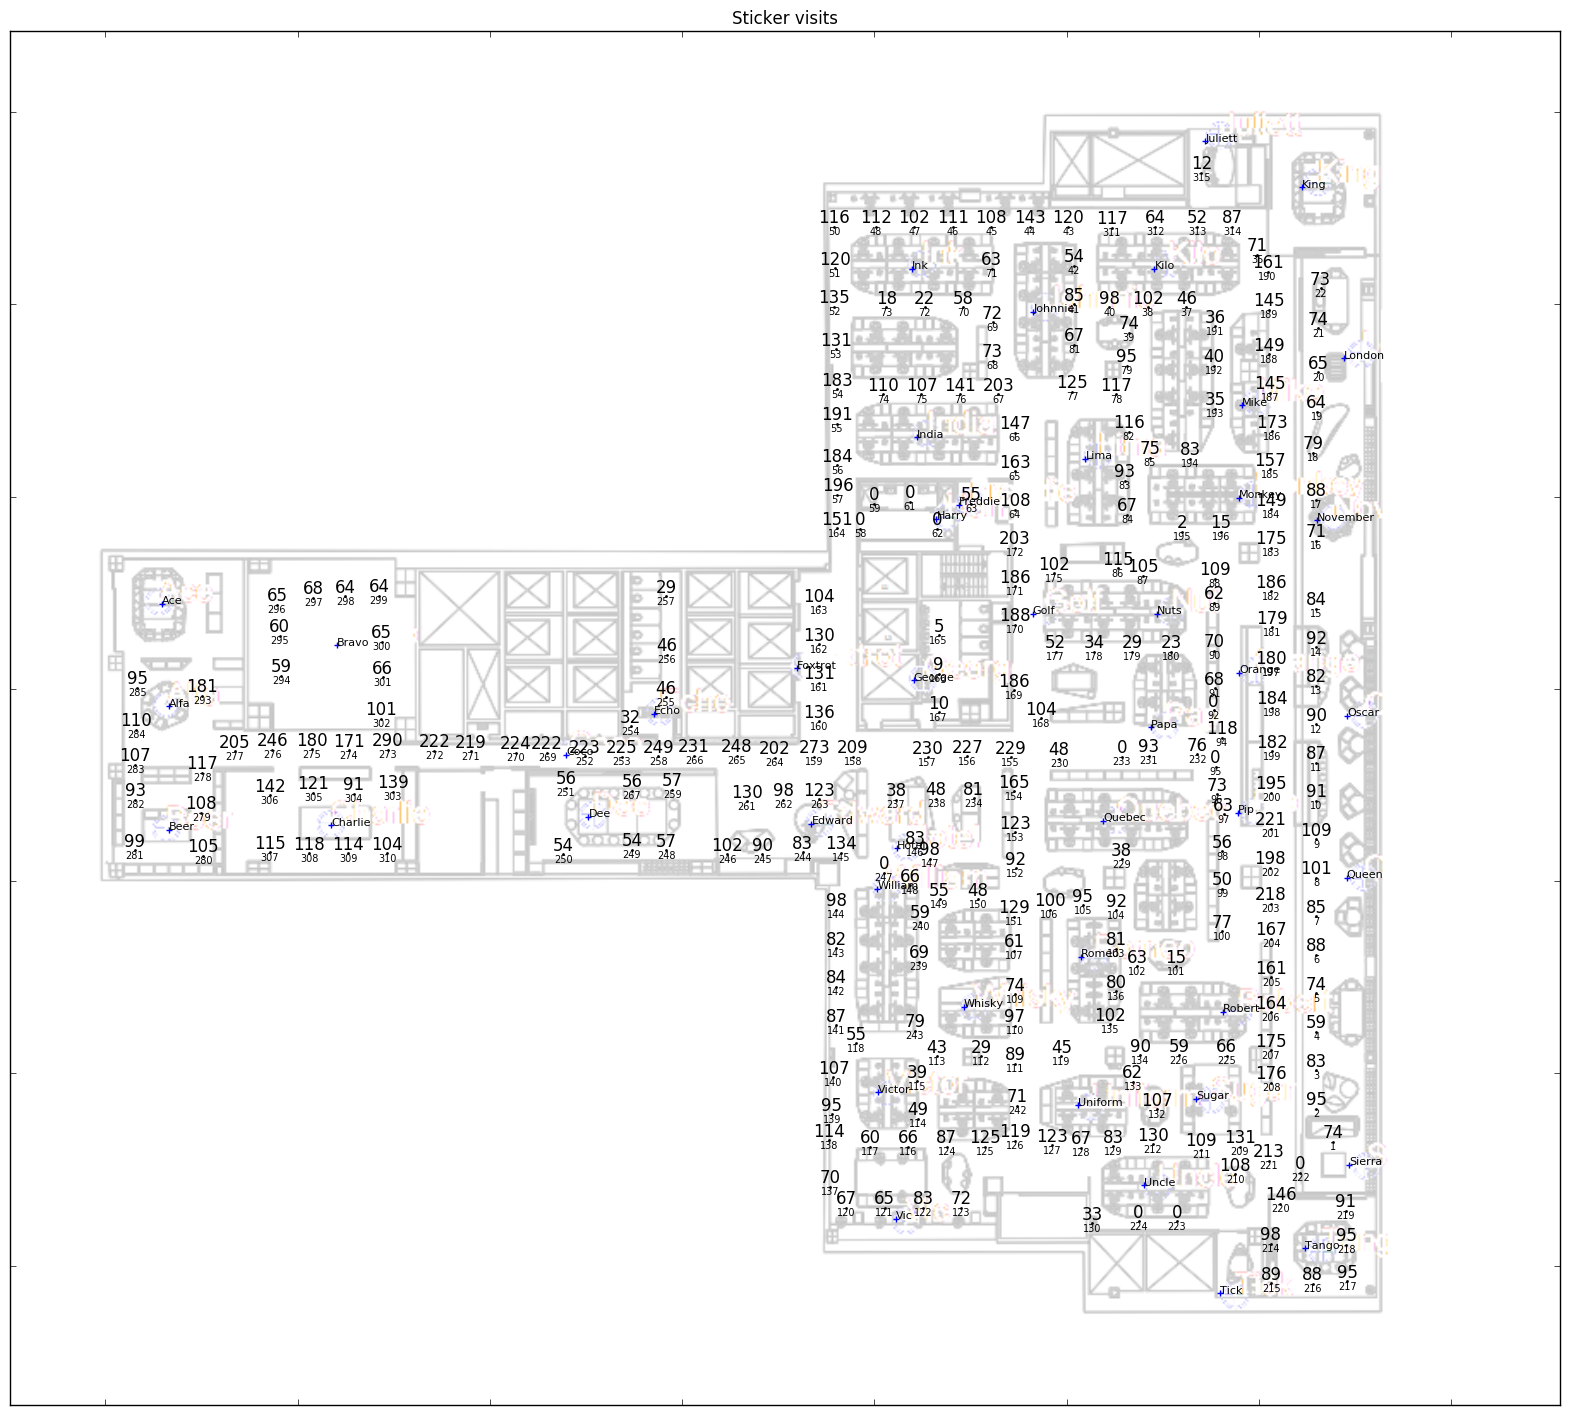

In [32]:
fig, ax = plt.subplots()

plt.title("Sticker visits")

#the sticker labels
for row in stickerLocations.iterrows():
    row = row[1] #BS indexing
    
    rowStickerID = int(row.stickerID)
    detectionCount = "duff"
    detectionCount = allUniqueDetections[allUniqueDetections.stickerID == rowStickerID].shape[0]
#     label = "{0}:\n{1}".format(rowStickerID, detectionCount)
    ax.text(row.x, row.y, rowStickerID,   fontsize= 7,  ha='center', va='top')
    ax.text(row.x, row.y, detectionCount, fontsize=12,  ha='center', va='bottom')

#sticker dots
ax.scatter(stickerLocations.x, stickerLocations.y, s=1, c="y")


#put the image on the graph as an underlay
img = imread("map.png")
ax.imshow(img, zorder=0, extent=[-1300, 72000, -24000, 41000])
#                                [left,  right, bottom, top  ]

#put the baseStations on the map 
for index, row in baseStationData.iterrows():
    ax.text(row.x, row.y, row.agentName, fontsize=8)
ax.scatter(baseStationData.x,baseStationData.y, marker='+')

#Hide the axis numbers because they don't tell us much
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())


fig.savefig("counts.pdf", bbox_inches='tight')

plt.show() #don't show, we need to save

In [15]:
# from scipy.spatial import Voronoi, voronoi_plot_2d

# vor = Voronoi([[x[0],x[1]] for x in zip(stickerLocations.x,stickerLocations.y)])
# voronoi_plot_2d(vor)